### They inner atoms, and the outer atoms are equally spaced

In [85]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation

In [86]:
########################################                 Define constants                   #############################################
N = 9

x_0      = 0.2
x_max    = 1.5
x_size   = 25

phi_0    = 0
phi_max  = 2 * np.pi / 3
phi_size = 10

t_max    = 40
t_size   = 100

fixed_dist_in  = 1
fixed_dist_ext  = 1
fixed_phi  = 0
fixed_gamma = 1
fixed_dist  = 1
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma
phis   = np.linspace(phi_0, phi_max, phi_size)
dists  = np.linspace(x_0, x_max, x_size)

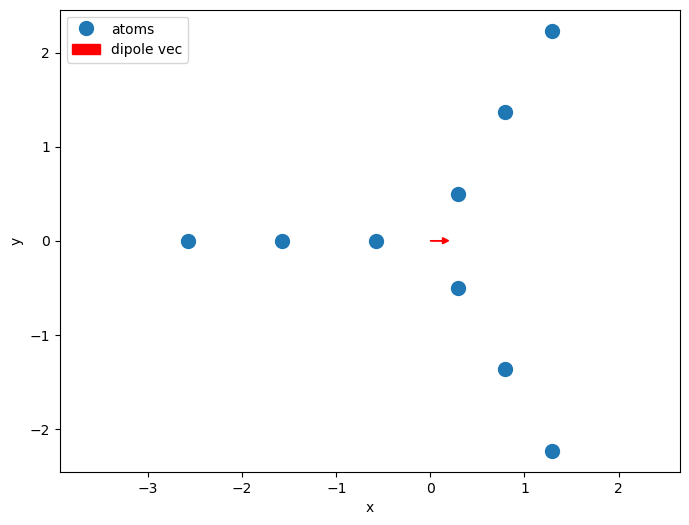

In [87]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its magnitude and direction angle phi."""
    phi = np.array([np.cos(phi), np.sin(phi)])
    return (phi / np.linalg.norm(phi))
d_hat = dipole_vector()

def atom_positions(d_in = fixed_dist_in, d_ext = fixed_dist_ext, N = N):
    """Returns the positions of the six atoms.
    
    Atoms 2, 3, and 4 form a triangle centered around the origin and atom 1 is on the negative x-axis.
    Atoms 5 and 6 continue to have the same angles as atoms 3 and 4, respectively.
    dij represents the distances between the atoms in a 2D shape.
    
    Parameters:
    d_in (float): Distance between inner atoms 2-3, 3-4, and 4-2.
    d_ext (float): Distance for outer atoms 3-5, 2-1, 4-6.
    
    Returns:
    np.ndarray: Positions of the six atoms as a 6x2 array.
    """
    Pos = np.zeros((N, 2))

    # Calculate the inner triangle vertices (atoms 2, 3, 4)
    cos = np.cos(2 * np.pi / 6) # 60 degrees in radians
    sin = np.sin(2 * np.pi / 6) # 60 degrees in radians
    x = d_in / (2 * np.cos(np.pi / 6)) # 30 deg
    Pos[0] = (- x, 0)
    Pos[1] = (+ x * cos, + x * sin)
    Pos[2] = (+ x * cos, - x * sin)

    for i in range((N-1) // 3):
        Pos[3 * (i+1)] = Pos[0]     + (- (i+1) * d_ext, 0)
        Pos[3 * (i+1) + 1] = Pos[1] + (+ (i+1) * d_ext * cos, + (i+1) * d_ext * sin)
        Pos[3 * (i+1) + 2] = Pos[2] + (+ (i+1) * d_ext * cos, - (i+1) * d_ext * sin)
    Pos_sorted = Pos[Pos[:, 0].argsort()]
    
    return Pos_sorted


# Example usage
positions = atom_positions(1, 1)
#print(positions)
#print(np.linalg.norm(positions[1]-positions[0]))
# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
plt.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
# Plot dipole vectors
#for i, position in enumerate(positions):
#    plt.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
#              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

In [89]:
########################################             create the Hamiltonean                 #################################################
def ladder_operator(i, operator_type, N = N):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N = N):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states

def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()

def H_eff(distance_in: float = fixed_dist,
          distance_ext: float = fixed_dist,
          phi: float = fixed_phi,
          gamma: float = fixed_gamma,
          N: int = N):

    d_hat = dipole_vector(phi)
    pos = atom_positions(distance_in, distance_ext)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, 'raising')
            lowering_op_j = ladder_operator(j+1, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma

def H_eff_red(distance_in: float = fixed_dist,
              distance_ext: float = fixed_dist,
              phi: float = fixed_phi,
              gamma: float = fixed_gamma,
              N: int = N):
    
    H = H_eff(distance_in, distance_ext, phi, gamma, N)
    single_exc_basis = single_excitation_basis(N)
    H_reduced = np.zeros((N, N), dtype=complex)

    for i, bra in enumerate(single_exc_basis):
        for j, ket in enumerate(single_exc_basis):
            H_reduced[i, j] = H.matrix_element(bra.dag(), ket)

    return Qobj(H_reduced)

In [90]:
# example form of the Hamiltonean
H_red_ex = H_eff_red(distance_in=0.3, distance_ext=0.3)
print(H_red_ex)

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.33229883-0.34346537j  0.0846859 -0.06893029j
   0.02529327+0.04236266j  0.02529327+0.04236266j -0.02967735+0.01104892j
  -0.02967735+0.01104892j  0.0014718 -0.02724437j  0.0014718 -0.02724437j]
 [-0.33229883-0.34346537j  0.        -0.5j        -0.33229883-0.34346537j
   0.08540429-0.06929815j  0.08540429-0.06929815j  0.01369179+0.05417356j
   0.01369179+0.05417356j -0.04407479-0.01147179j -0.04407479-0.01147179j]
 [ 0.0846859 -0.06893029j -0.33229883-0.34346537j  0.        -0.5j
  -0.17694828-0.30926919j -0.17694828-0.30926919j  0.11075175+0.02826149j
   0.11075175+0.02826149j -0.05268394+0.06254102j -0.05268394+0.06254102j]
 [ 0.02529327+0.04236266j  0.08540429-0.06929815j -0.17694828-0.30926919j
   0.        -0.5j         0.28910337-0.20668068j  0.13375282-0.24087685j
   0.13609921+0.12582113j  0.11012588+0.09631841j -0.09358447+0.07312495j]
 [ 0.02529327+0.0

In [100]:
def total_phases(distances, N = N):
    total_ps = np.zeros((len(distances), len(phis)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        for j, phi in enumerate(phis):
            dist_in = distance
            dist_ext = distance
            H = H_eff_red(dist_in, dist_ext, phi = phi)
            p = (np.angle(H[N//3 - 1, N//3]) + np.angle(H[N//3 - 1, N//3+1]) +np.angle(H[N//3, N//3+1])) / np.pi
            total_ps[i, j] = p
    return total_ps

phases = total_phases(dists)

Iteration: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


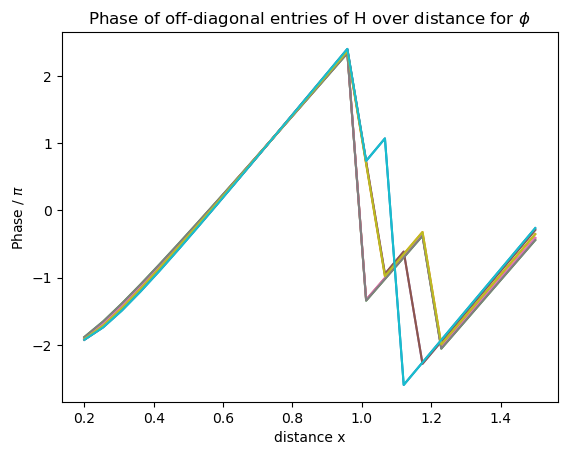

In [114]:
# plot phi(distances for a dipole orientation)
fig, ax = plt.subplots()
plt.plot(dists, phases, label=r'total Phase/ $\pi$')
plt.xlabel(r'distance x')
plt.ylabel(r'Phase / $\pi$')
plt.title(f'Phase of off-diagonal entries of H over distance for $\phi$')#={fixed_phi:.2f}
#plt.legend()
plt.show()